In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline    

#加载原始数据
raw_data = pd.read_csv("./dataSets/creditGrade_train_data.csv", encoding='gbk')
#缺失值处理
data = raw_data.fillna(0)

In [2]:
#2700*106
features_data = (data.drop(['id','label1','label2'],axis=1))
#5-class
target = data.label2
X = features_data.values.astype(np.float32) # 转换数据类型

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.3, random_state=123) # 参数test_size设置训练集占比

In [12]:
# Normalization
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')


#对分类进行one-hot编码
y_tr = one_hot(y_train.astype(np.int64),5)
y_vld = one_hot(y_test.astype(np.int64),5)

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("tensorflow运行版本：" + tf.__version__)

#设置相关参数
batch_size = 200    # Batch size
features_num = 106        # Number of steps
learning_rate = 0.0005
epochs = 1000

n_classes = 5
#一维数据，通道数设置为
n_channels = 1

log_dir = './logs'    # 输出日志保存的路径

graph = tf.Graph()
# Construct placeholders
with graph.as_default():
  
    inputs_ = tf.placeholder(tf.float32, [None,features_num ,n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.int64, [None, n_classes])
    #keep_prob目的是为了减少过拟合情况，动态调整让部分神经元参与训练过程
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 106, 1) --> (batch, 53, 18)
    print(inputs_)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=10, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu) 
    print(conv1)
    #conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob_)
    #max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    #print(max_pool_1)
    # (batch, 53, 18) --> (batch, 27, 36)
    conv2 = tf.layers.conv1d(inputs=conv1, filters=20, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    #print(max_pool_2)
    # (batch, 27, 36) --> (batch, 14, 72)
    #conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob_)
    conv3 = tf.layers.conv1d(inputs=conv2, filters=40, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob_)
    # (batch, 14, 72) --> (batch, 7, 144)
    conv4 = tf.layers.conv1d(inputs=conv3, filters=80, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    print(conv4)

with graph.as_default():
    # Flatten and add dropout,一个神经元的输出在dropout时不被丢弃的概率
    flat = tf.reshape(conv4, (-1,106*80))  
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    #经网络的最后一层是逻辑层，这层会返回我们的预测原始结果值
    #代价函数参数[batch_size,n_class]
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
        #二次代价函数，计算预测值与真实值之间的误差代价值-loss，其中第一个参数logits为最后一层输出，第二个为训练目标值即分类值
        #先通过Softmax函数，输出X对应输出每一类的概率大小，其次和真实值进行“交叉熵”，最终，对向量求均值，得到代价loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))


    #梯度下降法，数据量选择AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
        #correct_pred 返回一个布尔型数组，通过转化为0-1值后来计算准确率
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    print(correct_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #预测值
    pred = tf.argmax(logits, axis=1, name="predicted")
    print(pred)
    #正确值
    label = tf.argmax(labels_, 1)

tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar('loss_function', cost)

if (os.path.exists('./checkpoints') == False):
    !mkdir checkpoints

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    # summaries合并
    merged = tf.summary.merge_all()    
    # 写到指定的磁盘路径中
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_tr, batch_size):
            x = x.reshape((batch_size, features_num, n_channels))
            # Feed dictionary
            #keep_prob：0.5表示只有一半神经元运行在网络
            feed = {inputs_ : x, labels_ : y,keep_prob_ : 0.4, learning_rate_ : learning_rate}
             # Loss
            summary_str, loss, _ , acc = sess.run([merged, cost, optimizer, accuracy], feed_dict = feed)
         
            train_acc.append(acc)
            train_loss.append(loss)
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
                train_writer.add_summary(summary_str, e);
            # Compute validation loss at every 10 iterations
            if (iteration % 10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_test, y_vld, batch_size):
                    x_v = x_v.reshape(batch_size,features_num,n_channels)
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}                      
                    # Loss
                    summary, loss_v, acc_v, pred_labels = sess.run([merged, cost, accuracy, pred], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                    
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                test_writer.add_summary(summary, e);
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            # Iterate 
            iteration += 1    
            
        
    # 保存二进制模型
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['predicted'])
    with tf.gfile.FastGFile('creditGrades.pb', mode='wb') as f:
        f.write(output_graph_def.SerializeToString())
    
    saver.save(sess,"./checkpoints-cnn/creditGrade.ckpt")

tensorflow运行版本：1.3.0
Tensor("inputs:0", shape=(?, 106, 1), dtype=float32)
Tensor("conv1d/Relu:0", shape=(?, 106, 10), dtype=float32)
Tensor("conv1d_4/Relu:0", shape=(?, 106, 80), dtype=float32)
Tensor("Equal:0", shape=(?,), dtype=bool)
Tensor("predicted:0", shape=(?,), dtype=int64)
Epoch: 0/1000 Iteration: 5 Train loss: 1.543114 Train acc: 0.475000
Epoch: 1/1000 Iteration: 10 Train loss: 1.388856 Train acc: 0.495000
Epoch: 1/1000 Iteration: 10 Validation loss: 1.418395 Validation acc: 0.462500
Epoch: 1/1000 Iteration: 15 Train loss: 1.273262 Train acc: 0.475000
Epoch: 2/1000 Iteration: 20 Train loss: 1.276904 Train acc: 0.490000
Epoch: 2/1000 Iteration: 20 Validation loss: 1.286759 Validation acc: 0.462500
Epoch: 2/1000 Iteration: 25 Train loss: 1.278122 Train acc: 0.445000
Epoch: 3/1000 Iteration: 30 Train loss: 1.197361 Train acc: 0.480000
Epoch: 3/1000 Iteration: 30 Validation loss: 1.255725 Validation acc: 0.462500
Epoch: 3/1000 Iteration: 35 Train loss: 1.292115 Train acc: 0.43500

Epoch: 41/1000 Iteration: 375 Train loss: 0.807687 Train acc: 0.620000
Epoch: 42/1000 Iteration: 380 Train loss: 0.866814 Train acc: 0.610000
Epoch: 42/1000 Iteration: 380 Validation loss: 0.902584 Validation acc: 0.591250
Epoch: 42/1000 Iteration: 385 Train loss: 0.915957 Train acc: 0.555000
Epoch: 43/1000 Iteration: 390 Train loss: 0.835631 Train acc: 0.650000
Epoch: 43/1000 Iteration: 390 Validation loss: 0.899076 Validation acc: 0.595000
Epoch: 43/1000 Iteration: 395 Train loss: 0.848841 Train acc: 0.585000
Epoch: 44/1000 Iteration: 400 Train loss: 0.837673 Train acc: 0.655000
Epoch: 44/1000 Iteration: 400 Validation loss: 0.897739 Validation acc: 0.606250
Epoch: 44/1000 Iteration: 405 Train loss: 0.916135 Train acc: 0.590000
Epoch: 45/1000 Iteration: 410 Train loss: 0.854394 Train acc: 0.610000
Epoch: 45/1000 Iteration: 410 Validation loss: 0.896749 Validation acc: 0.605000
Epoch: 46/1000 Iteration: 415 Train loss: 0.811179 Train acc: 0.660000
Epoch: 46/1000 Iteration: 420 Train l

Epoch: 83/1000 Iteration: 750 Validation loss: 0.838510 Validation acc: 0.628750
Epoch: 83/1000 Iteration: 755 Train loss: 0.801784 Train acc: 0.600000
Epoch: 84/1000 Iteration: 760 Train loss: 0.709943 Train acc: 0.715000
Epoch: 84/1000 Iteration: 760 Validation loss: 0.836153 Validation acc: 0.627500
Epoch: 84/1000 Iteration: 765 Train loss: 0.758881 Train acc: 0.675000
Epoch: 85/1000 Iteration: 770 Train loss: 0.766289 Train acc: 0.660000
Epoch: 85/1000 Iteration: 770 Validation loss: 0.838889 Validation acc: 0.626250
Epoch: 86/1000 Iteration: 775 Train loss: 0.724593 Train acc: 0.705000
Epoch: 86/1000 Iteration: 780 Train loss: 0.695038 Train acc: 0.695000
Epoch: 86/1000 Iteration: 780 Validation loss: 0.838579 Validation acc: 0.630000
Epoch: 87/1000 Iteration: 785 Train loss: 0.697886 Train acc: 0.710000
Epoch: 87/1000 Iteration: 790 Train loss: 0.758456 Train acc: 0.625000
Epoch: 87/1000 Iteration: 790 Validation loss: 0.833787 Validation acc: 0.631250
Epoch: 88/1000 Iteration: 7

Epoch: 124/1000 Iteration: 1125 Train loss: 0.676373 Train acc: 0.715000
Epoch: 125/1000 Iteration: 1130 Train loss: 0.705532 Train acc: 0.725000
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.834549 Validation acc: 0.638750
Epoch: 126/1000 Iteration: 1135 Train loss: 0.670717 Train acc: 0.705000
Epoch: 126/1000 Iteration: 1140 Train loss: 0.628260 Train acc: 0.715000
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.830922 Validation acc: 0.642500
Epoch: 127/1000 Iteration: 1145 Train loss: 0.623604 Train acc: 0.755000
Epoch: 127/1000 Iteration: 1150 Train loss: 0.737923 Train acc: 0.655000
Epoch: 127/1000 Iteration: 1150 Validation loss: 0.832397 Validation acc: 0.643750
Epoch: 128/1000 Iteration: 1155 Train loss: 0.581672 Train acc: 0.755000
Epoch: 128/1000 Iteration: 1160 Train loss: 0.682090 Train acc: 0.710000
Epoch: 128/1000 Iteration: 1160 Validation loss: 0.824816 Validation acc: 0.643750
Epoch: 129/1000 Iteration: 1165 Train loss: 0.610748 Train acc: 0.775000
Epoch: 129/

Epoch: 165/1000 Iteration: 1490 Validation loss: 0.824943 Validation acc: 0.648750
Epoch: 166/1000 Iteration: 1495 Train loss: 0.649815 Train acc: 0.730000
Epoch: 166/1000 Iteration: 1500 Train loss: 0.585278 Train acc: 0.750000
Epoch: 166/1000 Iteration: 1500 Validation loss: 0.824494 Validation acc: 0.651250
Epoch: 167/1000 Iteration: 1505 Train loss: 0.647381 Train acc: 0.715000
Epoch: 167/1000 Iteration: 1510 Train loss: 0.674291 Train acc: 0.695000
Epoch: 167/1000 Iteration: 1510 Validation loss: 0.820557 Validation acc: 0.655000
Epoch: 168/1000 Iteration: 1515 Train loss: 0.560190 Train acc: 0.765000
Epoch: 168/1000 Iteration: 1520 Train loss: 0.654664 Train acc: 0.715000
Epoch: 168/1000 Iteration: 1520 Validation loss: 0.828482 Validation acc: 0.648750
Epoch: 169/1000 Iteration: 1525 Train loss: 0.654335 Train acc: 0.725000
Epoch: 169/1000 Iteration: 1530 Train loss: 0.640879 Train acc: 0.705000
Epoch: 169/1000 Iteration: 1530 Validation loss: 0.825618 Validation acc: 0.655000
E

Epoch: 206/1000 Iteration: 1860 Validation loss: 0.816325 Validation acc: 0.667500
Epoch: 207/1000 Iteration: 1865 Train loss: 0.660162 Train acc: 0.695000
Epoch: 207/1000 Iteration: 1870 Train loss: 0.641587 Train acc: 0.695000
Epoch: 207/1000 Iteration: 1870 Validation loss: 0.819210 Validation acc: 0.668750
Epoch: 208/1000 Iteration: 1875 Train loss: 0.538993 Train acc: 0.755000
Epoch: 208/1000 Iteration: 1880 Train loss: 0.627355 Train acc: 0.710000
Epoch: 208/1000 Iteration: 1880 Validation loss: 0.828172 Validation acc: 0.663750
Epoch: 209/1000 Iteration: 1885 Train loss: 0.578760 Train acc: 0.780000
Epoch: 209/1000 Iteration: 1890 Train loss: 0.644981 Train acc: 0.720000
Epoch: 209/1000 Iteration: 1890 Validation loss: 0.826564 Validation acc: 0.660000
Epoch: 210/1000 Iteration: 1895 Train loss: 0.634365 Train acc: 0.700000
Epoch: 211/1000 Iteration: 1900 Train loss: 0.620415 Train acc: 0.710000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.816242 Validation acc: 0.663750
E

Epoch: 247/1000 Iteration: 2225 Train loss: 0.577325 Train acc: 0.780000
Epoch: 247/1000 Iteration: 2230 Train loss: 0.592767 Train acc: 0.735000
Epoch: 247/1000 Iteration: 2230 Validation loss: 0.814926 Validation acc: 0.673750
Epoch: 248/1000 Iteration: 2235 Train loss: 0.477653 Train acc: 0.785000
Epoch: 248/1000 Iteration: 2240 Train loss: 0.635606 Train acc: 0.750000
Epoch: 248/1000 Iteration: 2240 Validation loss: 0.812934 Validation acc: 0.675000
Epoch: 249/1000 Iteration: 2245 Train loss: 0.595365 Train acc: 0.790000
Epoch: 249/1000 Iteration: 2250 Train loss: 0.595684 Train acc: 0.740000
Epoch: 249/1000 Iteration: 2250 Validation loss: 0.808115 Validation acc: 0.682500
Epoch: 250/1000 Iteration: 2255 Train loss: 0.600703 Train acc: 0.760000
Epoch: 251/1000 Iteration: 2260 Train loss: 0.623647 Train acc: 0.735000
Epoch: 251/1000 Iteration: 2260 Validation loss: 0.822916 Validation acc: 0.662500
Epoch: 251/1000 Iteration: 2265 Train loss: 0.565022 Train acc: 0.770000
Epoch: 252/

Epoch: 287/1000 Iteration: 2590 Train loss: 0.590003 Train acc: 0.745000
Epoch: 287/1000 Iteration: 2590 Validation loss: 0.796924 Validation acc: 0.683750
Epoch: 288/1000 Iteration: 2595 Train loss: 0.465269 Train acc: 0.815000
Epoch: 288/1000 Iteration: 2600 Train loss: 0.639881 Train acc: 0.740000
Epoch: 288/1000 Iteration: 2600 Validation loss: 0.799301 Validation acc: 0.687500
Epoch: 289/1000 Iteration: 2605 Train loss: 0.549340 Train acc: 0.795000
Epoch: 289/1000 Iteration: 2610 Train loss: 0.533105 Train acc: 0.765000
Epoch: 289/1000 Iteration: 2610 Validation loss: 0.799673 Validation acc: 0.690000
Epoch: 290/1000 Iteration: 2615 Train loss: 0.553815 Train acc: 0.810000
Epoch: 291/1000 Iteration: 2620 Train loss: 0.638029 Train acc: 0.740000
Epoch: 291/1000 Iteration: 2620 Validation loss: 0.810650 Validation acc: 0.673750
Epoch: 291/1000 Iteration: 2625 Train loss: 0.504543 Train acc: 0.795000
Epoch: 292/1000 Iteration: 2630 Train loss: 0.522924 Train acc: 0.795000
Epoch: 292/

Epoch: 328/1000 Iteration: 2960 Validation loss: 0.779196 Validation acc: 0.695000
Epoch: 329/1000 Iteration: 2965 Train loss: 0.548361 Train acc: 0.780000
Epoch: 329/1000 Iteration: 2970 Train loss: 0.514304 Train acc: 0.780000
Epoch: 329/1000 Iteration: 2970 Validation loss: 0.782613 Validation acc: 0.685000
Epoch: 330/1000 Iteration: 2975 Train loss: 0.562517 Train acc: 0.760000
Epoch: 331/1000 Iteration: 2980 Train loss: 0.587212 Train acc: 0.730000
Epoch: 331/1000 Iteration: 2980 Validation loss: 0.790925 Validation acc: 0.680000
Epoch: 331/1000 Iteration: 2985 Train loss: 0.532959 Train acc: 0.770000
Epoch: 332/1000 Iteration: 2990 Train loss: 0.548775 Train acc: 0.775000
Epoch: 332/1000 Iteration: 2990 Validation loss: 0.781486 Validation acc: 0.687500
Epoch: 332/1000 Iteration: 2995 Train loss: 0.598181 Train acc: 0.750000
Epoch: 333/1000 Iteration: 3000 Train loss: 0.480003 Train acc: 0.825000
Epoch: 333/1000 Iteration: 3000 Validation loss: 0.780873 Validation acc: 0.690000
E

Epoch: 369/1000 Iteration: 3325 Train loss: 0.513600 Train acc: 0.795000
Epoch: 369/1000 Iteration: 3330 Train loss: 0.550314 Train acc: 0.785000
Epoch: 369/1000 Iteration: 3330 Validation loss: 0.790070 Validation acc: 0.685000
Epoch: 370/1000 Iteration: 3335 Train loss: 0.538121 Train acc: 0.745000
Epoch: 371/1000 Iteration: 3340 Train loss: 0.540178 Train acc: 0.770000
Epoch: 371/1000 Iteration: 3340 Validation loss: 0.782019 Validation acc: 0.685000
Epoch: 371/1000 Iteration: 3345 Train loss: 0.540722 Train acc: 0.810000
Epoch: 372/1000 Iteration: 3350 Train loss: 0.503349 Train acc: 0.755000
Epoch: 372/1000 Iteration: 3350 Validation loss: 0.782727 Validation acc: 0.678750
Epoch: 372/1000 Iteration: 3355 Train loss: 0.581223 Train acc: 0.755000
Epoch: 373/1000 Iteration: 3360 Train loss: 0.459930 Train acc: 0.825000
Epoch: 373/1000 Iteration: 3360 Validation loss: 0.767459 Validation acc: 0.692500
Epoch: 373/1000 Iteration: 3365 Train loss: 0.511951 Train acc: 0.805000
Epoch: 374/

Epoch: 409/1000 Iteration: 3690 Train loss: 0.521580 Train acc: 0.780000
Epoch: 409/1000 Iteration: 3690 Validation loss: 0.769075 Validation acc: 0.696250
Epoch: 410/1000 Iteration: 3695 Train loss: 0.527446 Train acc: 0.800000
Epoch: 411/1000 Iteration: 3700 Train loss: 0.523428 Train acc: 0.750000
Epoch: 411/1000 Iteration: 3700 Validation loss: 0.761440 Validation acc: 0.697500
Epoch: 411/1000 Iteration: 3705 Train loss: 0.502899 Train acc: 0.760000
Epoch: 412/1000 Iteration: 3710 Train loss: 0.452043 Train acc: 0.825000
Epoch: 412/1000 Iteration: 3710 Validation loss: 0.756426 Validation acc: 0.701250
Epoch: 412/1000 Iteration: 3715 Train loss: 0.583776 Train acc: 0.740000
Epoch: 413/1000 Iteration: 3720 Train loss: 0.441206 Train acc: 0.805000
Epoch: 413/1000 Iteration: 3720 Validation loss: 0.764375 Validation acc: 0.696250
Epoch: 413/1000 Iteration: 3725 Train loss: 0.521438 Train acc: 0.765000
Epoch: 414/1000 Iteration: 3730 Train loss: 0.541777 Train acc: 0.770000
Epoch: 414/

Epoch: 449/1000 Iteration: 4050 Train loss: 0.498269 Train acc: 0.790000
Epoch: 449/1000 Iteration: 4050 Validation loss: 0.755636 Validation acc: 0.710000
Epoch: 450/1000 Iteration: 4055 Train loss: 0.517893 Train acc: 0.810000
Epoch: 451/1000 Iteration: 4060 Train loss: 0.552716 Train acc: 0.775000
Epoch: 451/1000 Iteration: 4060 Validation loss: 0.750132 Validation acc: 0.710000
Epoch: 451/1000 Iteration: 4065 Train loss: 0.492888 Train acc: 0.735000
Epoch: 452/1000 Iteration: 4070 Train loss: 0.512330 Train acc: 0.800000
Epoch: 452/1000 Iteration: 4070 Validation loss: 0.751075 Validation acc: 0.706250
Epoch: 452/1000 Iteration: 4075 Train loss: 0.595892 Train acc: 0.755000
Epoch: 453/1000 Iteration: 4080 Train loss: 0.461949 Train acc: 0.800000
Epoch: 453/1000 Iteration: 4080 Validation loss: 0.749067 Validation acc: 0.707500
Epoch: 453/1000 Iteration: 4085 Train loss: 0.548266 Train acc: 0.775000
Epoch: 454/1000 Iteration: 4090 Train loss: 0.512963 Train acc: 0.750000
Epoch: 454/

Epoch: 489/1000 Iteration: 4410 Train loss: 0.479619 Train acc: 0.775000
Epoch: 489/1000 Iteration: 4410 Validation loss: 0.749049 Validation acc: 0.693750
Epoch: 490/1000 Iteration: 4415 Train loss: 0.545606 Train acc: 0.795000
Epoch: 491/1000 Iteration: 4420 Train loss: 0.530858 Train acc: 0.765000
Epoch: 491/1000 Iteration: 4420 Validation loss: 0.738670 Validation acc: 0.706250
Epoch: 491/1000 Iteration: 4425 Train loss: 0.523391 Train acc: 0.805000
Epoch: 492/1000 Iteration: 4430 Train loss: 0.427927 Train acc: 0.805000
Epoch: 492/1000 Iteration: 4430 Validation loss: 0.736940 Validation acc: 0.705000
Epoch: 492/1000 Iteration: 4435 Train loss: 0.560301 Train acc: 0.755000
Epoch: 493/1000 Iteration: 4440 Train loss: 0.440313 Train acc: 0.840000
Epoch: 493/1000 Iteration: 4440 Validation loss: 0.735980 Validation acc: 0.706250
Epoch: 493/1000 Iteration: 4445 Train loss: 0.474364 Train acc: 0.820000
Epoch: 494/1000 Iteration: 4450 Train loss: 0.459458 Train acc: 0.830000
Epoch: 494/

Epoch: 529/1000 Iteration: 4770 Train loss: 0.480983 Train acc: 0.780000
Epoch: 529/1000 Iteration: 4770 Validation loss: 0.759954 Validation acc: 0.691250
Epoch: 530/1000 Iteration: 4775 Train loss: 0.508714 Train acc: 0.790000
Epoch: 531/1000 Iteration: 4780 Train loss: 0.497050 Train acc: 0.780000
Epoch: 531/1000 Iteration: 4780 Validation loss: 0.743526 Validation acc: 0.711250
Epoch: 531/1000 Iteration: 4785 Train loss: 0.465786 Train acc: 0.795000
Epoch: 532/1000 Iteration: 4790 Train loss: 0.481796 Train acc: 0.785000
Epoch: 532/1000 Iteration: 4790 Validation loss: 0.733874 Validation acc: 0.712500
Epoch: 532/1000 Iteration: 4795 Train loss: 0.505925 Train acc: 0.770000
Epoch: 533/1000 Iteration: 4800 Train loss: 0.458719 Train acc: 0.805000
Epoch: 533/1000 Iteration: 4800 Validation loss: 0.735316 Validation acc: 0.716250
Epoch: 533/1000 Iteration: 4805 Train loss: 0.501937 Train acc: 0.790000
Epoch: 534/1000 Iteration: 4810 Train loss: 0.447430 Train acc: 0.820000
Epoch: 534/

Epoch: 569/1000 Iteration: 5130 Train loss: 0.445714 Train acc: 0.825000
Epoch: 569/1000 Iteration: 5130 Validation loss: 0.726622 Validation acc: 0.711250
Epoch: 570/1000 Iteration: 5135 Train loss: 0.482024 Train acc: 0.795000
Epoch: 571/1000 Iteration: 5140 Train loss: 0.509906 Train acc: 0.775000
Epoch: 571/1000 Iteration: 5140 Validation loss: 0.731882 Validation acc: 0.722500
Epoch: 571/1000 Iteration: 5145 Train loss: 0.471981 Train acc: 0.775000
Epoch: 572/1000 Iteration: 5150 Train loss: 0.408752 Train acc: 0.810000
Epoch: 572/1000 Iteration: 5150 Validation loss: 0.719884 Validation acc: 0.716250
Epoch: 572/1000 Iteration: 5155 Train loss: 0.569173 Train acc: 0.775000
Epoch: 573/1000 Iteration: 5160 Train loss: 0.414950 Train acc: 0.830000
Epoch: 573/1000 Iteration: 5160 Validation loss: 0.728632 Validation acc: 0.712500
Epoch: 573/1000 Iteration: 5165 Train loss: 0.459875 Train acc: 0.805000
Epoch: 574/1000 Iteration: 5170 Train loss: 0.502173 Train acc: 0.775000
Epoch: 574/

Epoch: 611/1000 Iteration: 5500 Train loss: 0.519422 Train acc: 0.800000
Epoch: 611/1000 Iteration: 5500 Validation loss: 0.722773 Validation acc: 0.718750
Epoch: 611/1000 Iteration: 5505 Train loss: 0.479023 Train acc: 0.775000
Epoch: 612/1000 Iteration: 5510 Train loss: 0.400981 Train acc: 0.805000
Epoch: 612/1000 Iteration: 5510 Validation loss: 0.719298 Validation acc: 0.721250
Epoch: 612/1000 Iteration: 5515 Train loss: 0.491467 Train acc: 0.750000
Epoch: 613/1000 Iteration: 5520 Train loss: 0.436094 Train acc: 0.840000
Epoch: 613/1000 Iteration: 5520 Validation loss: 0.724422 Validation acc: 0.720000
Epoch: 613/1000 Iteration: 5525 Train loss: 0.451587 Train acc: 0.810000
Epoch: 614/1000 Iteration: 5530 Train loss: 0.425292 Train acc: 0.820000
Epoch: 614/1000 Iteration: 5530 Validation loss: 0.730270 Validation acc: 0.717500
Epoch: 614/1000 Iteration: 5535 Train loss: 0.451495 Train acc: 0.810000
Epoch: 615/1000 Iteration: 5540 Train loss: 0.443192 Train acc: 0.805000
Epoch: 615/

Epoch: 651/1000 Iteration: 5865 Train loss: 0.413848 Train acc: 0.825000
Epoch: 652/1000 Iteration: 5870 Train loss: 0.380408 Train acc: 0.805000
Epoch: 652/1000 Iteration: 5870 Validation loss: 0.713431 Validation acc: 0.725000
Epoch: 652/1000 Iteration: 5875 Train loss: 0.442478 Train acc: 0.820000
Epoch: 653/1000 Iteration: 5880 Train loss: 0.424837 Train acc: 0.860000
Epoch: 653/1000 Iteration: 5880 Validation loss: 0.717725 Validation acc: 0.727500
Epoch: 653/1000 Iteration: 5885 Train loss: 0.430375 Train acc: 0.810000
Epoch: 654/1000 Iteration: 5890 Train loss: 0.442758 Train acc: 0.835000
Epoch: 654/1000 Iteration: 5890 Validation loss: 0.724509 Validation acc: 0.727500
Epoch: 654/1000 Iteration: 5895 Train loss: 0.476051 Train acc: 0.810000
Epoch: 655/1000 Iteration: 5900 Train loss: 0.389762 Train acc: 0.815000
Epoch: 655/1000 Iteration: 5900 Validation loss: 0.715327 Validation acc: 0.735000
Epoch: 656/1000 Iteration: 5905 Train loss: 0.459006 Train acc: 0.805000
Epoch: 656/

Epoch: 691/1000 Iteration: 6225 Train loss: 0.394963 Train acc: 0.850000
Epoch: 692/1000 Iteration: 6230 Train loss: 0.375218 Train acc: 0.815000
Epoch: 692/1000 Iteration: 6230 Validation loss: 0.723861 Validation acc: 0.732500
Epoch: 692/1000 Iteration: 6235 Train loss: 0.440715 Train acc: 0.830000
Epoch: 693/1000 Iteration: 6240 Train loss: 0.418011 Train acc: 0.860000
Epoch: 693/1000 Iteration: 6240 Validation loss: 0.717408 Validation acc: 0.732500
Epoch: 693/1000 Iteration: 6245 Train loss: 0.433039 Train acc: 0.800000
Epoch: 694/1000 Iteration: 6250 Train loss: 0.505124 Train acc: 0.770000
Epoch: 694/1000 Iteration: 6250 Validation loss: 0.717470 Validation acc: 0.735000
Epoch: 694/1000 Iteration: 6255 Train loss: 0.436324 Train acc: 0.820000
Epoch: 695/1000 Iteration: 6260 Train loss: 0.423542 Train acc: 0.815000
Epoch: 695/1000 Iteration: 6260 Validation loss: 0.718145 Validation acc: 0.737500
Epoch: 696/1000 Iteration: 6265 Train loss: 0.463856 Train acc: 0.810000
Epoch: 696/

Epoch: 732/1000 Iteration: 6595 Train loss: 0.494735 Train acc: 0.775000
Epoch: 733/1000 Iteration: 6600 Train loss: 0.461748 Train acc: 0.815000
Epoch: 733/1000 Iteration: 6600 Validation loss: 0.713157 Validation acc: 0.735000
Epoch: 733/1000 Iteration: 6605 Train loss: 0.414642 Train acc: 0.815000
Epoch: 734/1000 Iteration: 6610 Train loss: 0.476319 Train acc: 0.805000
Epoch: 734/1000 Iteration: 6610 Validation loss: 0.720639 Validation acc: 0.735000
Epoch: 734/1000 Iteration: 6615 Train loss: 0.454979 Train acc: 0.785000
Epoch: 735/1000 Iteration: 6620 Train loss: 0.460347 Train acc: 0.810000
Epoch: 735/1000 Iteration: 6620 Validation loss: 0.718884 Validation acc: 0.731250
Epoch: 736/1000 Iteration: 6625 Train loss: 0.465881 Train acc: 0.810000
Epoch: 736/1000 Iteration: 6630 Train loss: 0.427514 Train acc: 0.825000
Epoch: 736/1000 Iteration: 6630 Validation loss: 0.718550 Validation acc: 0.742500
Epoch: 737/1000 Iteration: 6635 Train loss: 0.361462 Train acc: 0.845000
Epoch: 737/

Epoch: 773/1000 Iteration: 6960 Train loss: 0.394930 Train acc: 0.830000
Epoch: 773/1000 Iteration: 6960 Validation loss: 0.730313 Validation acc: 0.735000
Epoch: 773/1000 Iteration: 6965 Train loss: 0.404704 Train acc: 0.855000
Epoch: 774/1000 Iteration: 6970 Train loss: 0.478171 Train acc: 0.800000
Epoch: 774/1000 Iteration: 6970 Validation loss: 0.718115 Validation acc: 0.737500
Epoch: 774/1000 Iteration: 6975 Train loss: 0.451952 Train acc: 0.800000
Epoch: 775/1000 Iteration: 6980 Train loss: 0.455385 Train acc: 0.815000
Epoch: 775/1000 Iteration: 6980 Validation loss: 0.715693 Validation acc: 0.733750
Epoch: 776/1000 Iteration: 6985 Train loss: 0.442930 Train acc: 0.805000
Epoch: 776/1000 Iteration: 6990 Train loss: 0.412072 Train acc: 0.835000
Epoch: 776/1000 Iteration: 6990 Validation loss: 0.731340 Validation acc: 0.733750
Epoch: 777/1000 Iteration: 6995 Train loss: 0.361777 Train acc: 0.860000
Epoch: 777/1000 Iteration: 7000 Train loss: 0.443288 Train acc: 0.815000
Epoch: 777/

Epoch: 813/1000 Iteration: 7320 Train loss: 0.417412 Train acc: 0.835000
Epoch: 813/1000 Iteration: 7320 Validation loss: 0.710614 Validation acc: 0.738750
Epoch: 813/1000 Iteration: 7325 Train loss: 0.387142 Train acc: 0.840000
Epoch: 814/1000 Iteration: 7330 Train loss: 0.392537 Train acc: 0.845000
Epoch: 814/1000 Iteration: 7330 Validation loss: 0.712503 Validation acc: 0.742500
Epoch: 814/1000 Iteration: 7335 Train loss: 0.380954 Train acc: 0.835000
Epoch: 815/1000 Iteration: 7340 Train loss: 0.488034 Train acc: 0.760000
Epoch: 815/1000 Iteration: 7340 Validation loss: 0.713408 Validation acc: 0.747500
Epoch: 816/1000 Iteration: 7345 Train loss: 0.460256 Train acc: 0.790000
Epoch: 816/1000 Iteration: 7350 Train loss: 0.419413 Train acc: 0.810000
Epoch: 816/1000 Iteration: 7350 Validation loss: 0.710279 Validation acc: 0.737500
Epoch: 817/1000 Iteration: 7355 Train loss: 0.374791 Train acc: 0.825000
Epoch: 817/1000 Iteration: 7360 Train loss: 0.443663 Train acc: 0.790000
Epoch: 817/

Epoch: 853/1000 Iteration: 7680 Validation loss: 0.711139 Validation acc: 0.748750
Epoch: 853/1000 Iteration: 7685 Train loss: 0.393661 Train acc: 0.835000
Epoch: 854/1000 Iteration: 7690 Train loss: 0.428373 Train acc: 0.835000
Epoch: 854/1000 Iteration: 7690 Validation loss: 0.712925 Validation acc: 0.742500
Epoch: 854/1000 Iteration: 7695 Train loss: 0.408526 Train acc: 0.830000
Epoch: 855/1000 Iteration: 7700 Train loss: 0.374345 Train acc: 0.840000
Epoch: 855/1000 Iteration: 7700 Validation loss: 0.719048 Validation acc: 0.751250
Epoch: 856/1000 Iteration: 7705 Train loss: 0.456022 Train acc: 0.790000
Epoch: 856/1000 Iteration: 7710 Train loss: 0.391363 Train acc: 0.825000
Epoch: 856/1000 Iteration: 7710 Validation loss: 0.709451 Validation acc: 0.742500
Epoch: 857/1000 Iteration: 7715 Train loss: 0.386163 Train acc: 0.795000
Epoch: 857/1000 Iteration: 7720 Train loss: 0.428966 Train acc: 0.795000
Epoch: 857/1000 Iteration: 7720 Validation loss: 0.706283 Validation acc: 0.740000
E

Epoch: 894/1000 Iteration: 8050 Validation loss: 0.718723 Validation acc: 0.745000
Epoch: 894/1000 Iteration: 8055 Train loss: 0.497521 Train acc: 0.800000
Epoch: 895/1000 Iteration: 8060 Train loss: 0.410877 Train acc: 0.825000
Epoch: 895/1000 Iteration: 8060 Validation loss: 0.719462 Validation acc: 0.747500
Epoch: 896/1000 Iteration: 8065 Train loss: 0.477414 Train acc: 0.770000
Epoch: 896/1000 Iteration: 8070 Train loss: 0.425990 Train acc: 0.830000
Epoch: 896/1000 Iteration: 8070 Validation loss: 0.718585 Validation acc: 0.751250
Epoch: 897/1000 Iteration: 8075 Train loss: 0.360014 Train acc: 0.860000
Epoch: 897/1000 Iteration: 8080 Train loss: 0.445024 Train acc: 0.805000
Epoch: 897/1000 Iteration: 8080 Validation loss: 0.712894 Validation acc: 0.746250
Epoch: 898/1000 Iteration: 8085 Train loss: 0.363406 Train acc: 0.840000
Epoch: 898/1000 Iteration: 8090 Train loss: 0.377952 Train acc: 0.830000
Epoch: 898/1000 Iteration: 8090 Validation loss: 0.717330 Validation acc: 0.747500
E

Epoch: 935/1000 Iteration: 8420 Validation loss: 0.716906 Validation acc: 0.751250
Epoch: 936/1000 Iteration: 8425 Train loss: 0.440062 Train acc: 0.810000
Epoch: 936/1000 Iteration: 8430 Train loss: 0.457472 Train acc: 0.795000
Epoch: 936/1000 Iteration: 8430 Validation loss: 0.717374 Validation acc: 0.747500
Epoch: 937/1000 Iteration: 8435 Train loss: 0.361162 Train acc: 0.860000
Epoch: 937/1000 Iteration: 8440 Train loss: 0.368218 Train acc: 0.845000
Epoch: 937/1000 Iteration: 8440 Validation loss: 0.724022 Validation acc: 0.747500
Epoch: 938/1000 Iteration: 8445 Train loss: 0.372149 Train acc: 0.880000
Epoch: 938/1000 Iteration: 8450 Train loss: 0.356378 Train acc: 0.865000
Epoch: 938/1000 Iteration: 8450 Validation loss: 0.720596 Validation acc: 0.745000
Epoch: 939/1000 Iteration: 8455 Train loss: 0.453375 Train acc: 0.845000
Epoch: 939/1000 Iteration: 8460 Train loss: 0.450682 Train acc: 0.805000
Epoch: 939/1000 Iteration: 8460 Validation loss: 0.714200 Validation acc: 0.743750
E

Epoch: 976/1000 Iteration: 8790 Validation loss: 0.719168 Validation acc: 0.745000
Epoch: 977/1000 Iteration: 8795 Train loss: 0.314777 Train acc: 0.875000
Epoch: 977/1000 Iteration: 8800 Train loss: 0.458901 Train acc: 0.805000
Epoch: 977/1000 Iteration: 8800 Validation loss: 0.726922 Validation acc: 0.741250
Epoch: 978/1000 Iteration: 8805 Train loss: 0.343496 Train acc: 0.855000
Epoch: 978/1000 Iteration: 8810 Train loss: 0.324328 Train acc: 0.890000
Epoch: 978/1000 Iteration: 8810 Validation loss: 0.716939 Validation acc: 0.743750
Epoch: 979/1000 Iteration: 8815 Train loss: 0.413173 Train acc: 0.815000
Epoch: 979/1000 Iteration: 8820 Train loss: 0.410270 Train acc: 0.810000
Epoch: 979/1000 Iteration: 8820 Validation loss: 0.716868 Validation acc: 0.756250
Epoch: 980/1000 Iteration: 8825 Train loss: 0.442419 Train acc: 0.805000
Epoch: 981/1000 Iteration: 8830 Train loss: 0.457753 Train acc: 0.815000
Epoch: 981/1000 Iteration: 8830 Validation loss: 0.717531 Validation acc: 0.756250
E

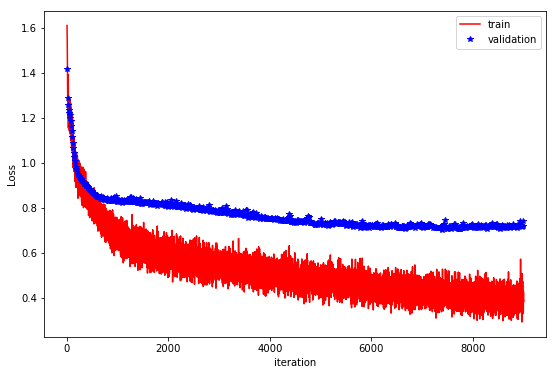

In [13]:
t = np.arange(iteration-1)
plt.figure(figsize = (9,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

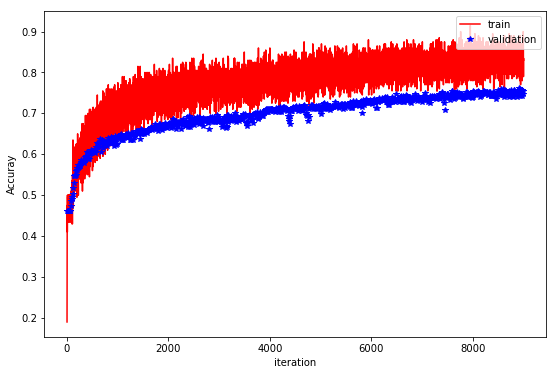

In [14]:
# Plot Accuracies
plt.figure(figsize = (9,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
test_acc = []
pred_labels = []
label = []
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_vld, batch_size):
        x_t = x_t.reshape((batch_size,features_num,n_channels))
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
       
        batch_acc = sess.run(accuracy, feed_dict=feed)
        preds = sess.run(pred, feed_dict=feed)
        labels = sess.run(label, feed_dict=feed)
        #max_index = np.argmax(prediction)
        #print(max_index)
        test_acc.append(batch_acc)
        pred_labels.append(preds)
        label.append(labels)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("pred value", pred_labels)

INFO:tensorflow:Restoring parameters from checkpoints-cnn/creditGrade.ckpt
Test accuracy: 0.755000
pred value [array([2, 3, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 3, 1, 2, 2, 1, 2, 0, 2, 3, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 3, 1, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       1, 2, 1, 3, 1, 1, 3, 2, 0, 3, 1, 2, 1, 2, 1, 2, 3, 1, 3, 3, 2, 1, 1,
       0, 2, 1, 2, 0, 2, 1, 3, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1,
       1, 2, 2, 2, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 0,
       1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 3, 3, 2, 2, 3, 2, 3, 0, 2, 2,
       2, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 2, 3, 1, 2, 3, 1, 2, 2,
       2, 3, 3, 1, 0, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 0, 3, 1, 2, 3, 3, 1,
       3, 1, 1, 3, 2, 0, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2]), array([0, 3, 2, 2, 1, 2, 1, 3, 0, 3, 1, 0, 2, 0, 1, 3, 2, 2, 1, 3, 1, 2, 2,
       0, 3, 1, 1, 2, 2, 3, 0, 0, 1, 2, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 0, 2, 3, 1, 2, 3, 2, 2, 3, 2, 1,

In [ ]:
# 20180807 demo 为测试java调用TensorFlow模型而写

#coding=utf-8
import tensorflow as tf


# 定义图
x = tf.placeholder(tf.float32, name="x")
y = tf.get_variable("y", initializer=10.0)
z = tf.log(x + y, name="z")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 进行一些训练代码，此处省略
    # xxxxxxxxxxxx

    # 显示图中的节点
    print([n.name for n in sess.graph.as_graph_def().node])
    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        sess.graph_def,
        output_node_names=["z"])

    # 保存图为pb文件
    with open('model.pb', 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())